In [1]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import imageio
import pickle

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


# Preparation

Like the previous notebook, function will be placed on TOP to ease loading

In [3]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
def resize_to_original(img, target_size):
    current_height, current_width = img.shape
    target_height, target_width = target_size
    if current_height >= target_height and current_width >= target_width:
        # we are in case where we expanded with black
        return img[:target_height, :target_width]
    else:
        scale = max(target_height, target_width) / 512
        scaled_image = cv2.resize(img, None, fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
        return scaled_image[:target_height, :target_width]
    return img

def compute_IoU(pred, mask, trigger=0.999):
    pred = (pred>trigger)
    mask = (mask>0.9)
    union = np.logical_or(pred, mask)
    intersection = np.logical_and(pred, mask)
    return intersection.sum()/union.sum()

In [5]:
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

We can now load our datas prepared previously. This include matrice of dimensions, images boosted, and masks resized to proper dimensions.

In [6]:
dimensions = np.array(load_obj("datas/dimensions"))
data = np.load('datas/dataset_resized.npz')
X_train, X_test, y_train, y_test, dim_train, dim_test = train_test_split(data["X"], data["y"], dimensions, test_size=0.1, random_state=42)

In [7]:
print(X_train.shape, " - ", y_train.shape, " - ", X_train.dtype)
print(X_test.shape, " - ", y_test.shape, " - ", X_test.dtype)
print(dim_train.shape, " - ", dim_test.shape, " - ", dim_train.dtype)

(603, 256, 256, 1)  -  (603, 256, 256, 1)  -  uint8
(67, 256, 256, 1)  -  (67, 256, 256, 1)  -  uint8
(603, 2)  -  (67, 2)  -  int32


In [8]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = X_train.shape[1:] # 512, 512, 1
BATCH_SIZE = 5
NB_IMAGES_TRAIN = X_train.shape[0]
NB_IMAGES_TEST = X_test.shape[0]
EPOCHS = 50
SEED = 42

# Model U-Net 

Thanks to <a href="https://www.kaggle.com/lscoelho/keras-u-net-lb-0-277-epochs-vsplit-thr">this Kernel</a>, I discovered the model presented on <a href="https://arxiv.org/pdf/1505.04597.pdf">arxiv</a>. Originally, I wanted to try to original version but in order to have the same output as input, I changed the padding and the input size to 512x512 to not have issue of round dimensions down.

In [5]:
# IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 572, 572, 1
# padding = "valid"

# inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = Lambda(lambda x: x / 255) (inputs)

# c1 = Conv2D(64, (3, 3), activation='relu', padding=padding) (s)   # 570 x 570
# c1 = Conv2D(64, (3, 3), activation='relu', padding=padding) (c1)  # 568 x 568
# d1 = Cropping2D(cropping=(88))                              (c1)  # 568 -> 392
# p1 = MaxPooling2D((2, 2)) (c1)                                    # 284 x 284

# c2 = Conv2D(128, (3, 3), activation='relu', padding=padding) (p1)  # 282 x 282
# c2 = Conv2D(128, (3, 3), activation='relu', padding=padding) (c2)  # 280 x 280
# d2 = Cropping2D(cropping=(40))                               (c2)  # 280 -> 200
# p2 = MaxPooling2D((2, 2)) (c2)                                     # 140 x 140           

# c3 = Conv2D(256, (3, 3), activation='relu', padding=padding) (p2)  # 138 x 138
# c3 = Conv2D(256, (3, 3), activation='relu', padding=padding) (c3)  # 136 x 136
# d3 = Cropping2D(cropping=(16))                               (c3)  # 136 -> 104 
# p3 = MaxPooling2D((2, 2)) (c3)                                     # 68 x 68

# c4 = Conv2D(512, (3, 3), activation='relu', padding=padding) (p3)  # 66 x 66
# c4 = Conv2D(512, (3, 3), activation='relu', padding=padding) (c4)  # 64 x 64
# d4 = Cropping2D(cropping=(4))                                (c4)  # 64 -> 56 (64-56)/2
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)                           # 32 x 32

# c5 = Conv2D(1024, (3, 3), activation='relu', padding=padding) (p4)  # 30 x 30
# c5 = Conv2D(1024, (3, 3), activation='relu', padding=padding) (c5)  # 28 x 28

# u6 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding=padding) (c5) # 56 x 56
# u6 = concatenate([u6, d4])
# c6 = Conv2D(512, (3, 3), activation='relu', padding=padding) (u6)   # 54 x 54
# c6 = Conv2D(512, (3, 3), activation='relu', padding=padding) (c6)   # 52 x 52

# u7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding=padding) (c6)  # 104 x 104
# u7 = concatenate([u7, d3])
# c7 = Conv2D(256, (3, 3), activation='relu', padding=padding) (u7)   # 102 x 102
# c7 = Conv2D(256, (3, 3), activation='relu', padding=padding) (c7)   # 100 x 100

# u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding=padding) (c7)  # 200 x 200
# u8 = concatenate([u8, d2])
# c8 = Conv2D(128, (3, 3), activation='relu', padding=padding) (u8)   # 198 x 198
# c8 = Conv2D(128, (3, 3), activation='relu', padding=padding) (c8)   # 196 x 196

# u9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=padding) (c8)  # 392 x 392
# u9 = concatenate([u9, d1], axis=3)
# c9 = Conv2D(64, (3, 3), activation='relu', padding=padding) (u9)   # 390 x 390
# c9 = Conv2D(64, (3, 3), activation='relu', padding=padding) (c9)   # 388 x 388
# c9 = Conv2D(2, (3, 3), activation='relu', padding="valid") (c9)    # 388 x 388

# outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

# model = Model(inputs=[inputs], outputs=[outputs])

To fix that, I've created another model with padding "same" and using a size power of 2 in order never have after max_pooling a dimension lost. The new model and pre-processing is present in models/model.py

We will now prepare generators to avoid overfitting. At the same time, it will convert our matrices from uint8 to float 32 per batch.

Epoch 1/50
120/120 [==============================] - 12s 104ms/step - loss: 0.2537 - binary_crossentropy: 0.2537 - val_loss: 0.1144 - val_binary_crossentropy: 0.1144
Epoch 2/50
120/120 [==============================] - 10s 85ms/step - loss: 0.1226 - binary_crossentropy: 0.1226 - val_loss: 0.1143 - val_binary_crossentropy: 0.1143
Epoch 3/50
120/120 [==============================] - 10s 84ms/step - loss: 0.1129 - binary_crossentropy: 0.1129 - val_loss: 0.1084 - val_binary_crossentropy: 0.1084
Epoch 4/50
120/120 [==============================] - 10s 85ms/step - loss: 0.1101 - binary_crossentropy: 0.1101 - val_loss: 0.0931 - val_binary_crossentropy: 0.0931
Epoch 5/50
120/120 [==============================] - 10s 86ms/step - loss: 0.1043 - binary_crossentropy: 0.1043 - val_loss: 0.1114 - val_binary_crossentropy: 0.1114
Epoch 6/50
120/120 [==============================] - 10s 87ms/step - loss: 0.1066 - binary_crossentropy: 0.1066 - val_loss: 0.0900 - val_binary_crossentropy: 0.0900
Epo

Epoch 50/50
120/120 [==============================] - 14s 113ms/step - loss: 0.0648 - binary_crossentropy: 0.0648 - val_loss: 0.0641 - val_binary_crossentropy: 0.0641


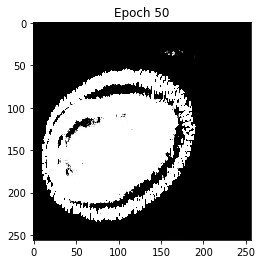

In [8]:
from models import model as md

model = md.create_model(h, w, c)
predictions = md.prediction_history(model, X_test, y_test, "unet")  #  1D, 2D, light, resized, rgb
train_generator, test_generator = md.create_generator(X_train, X_test, y_train, y_test, BATCH_SIZE=BATCH_SIZE, seed=SEED)

model.fit_generator(generator = train_generator, 
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE, 
                    callbacks = [predictions])

model.save("models/model_unet.h5")

In order to see the training, after every epoch, we will save the prediction on few fixed images from test set. This will be handled with a specific callback

Let's visualise for few test images the result. The first line is the image, the seond one is the predicted mask and the 3rd one is the given mask

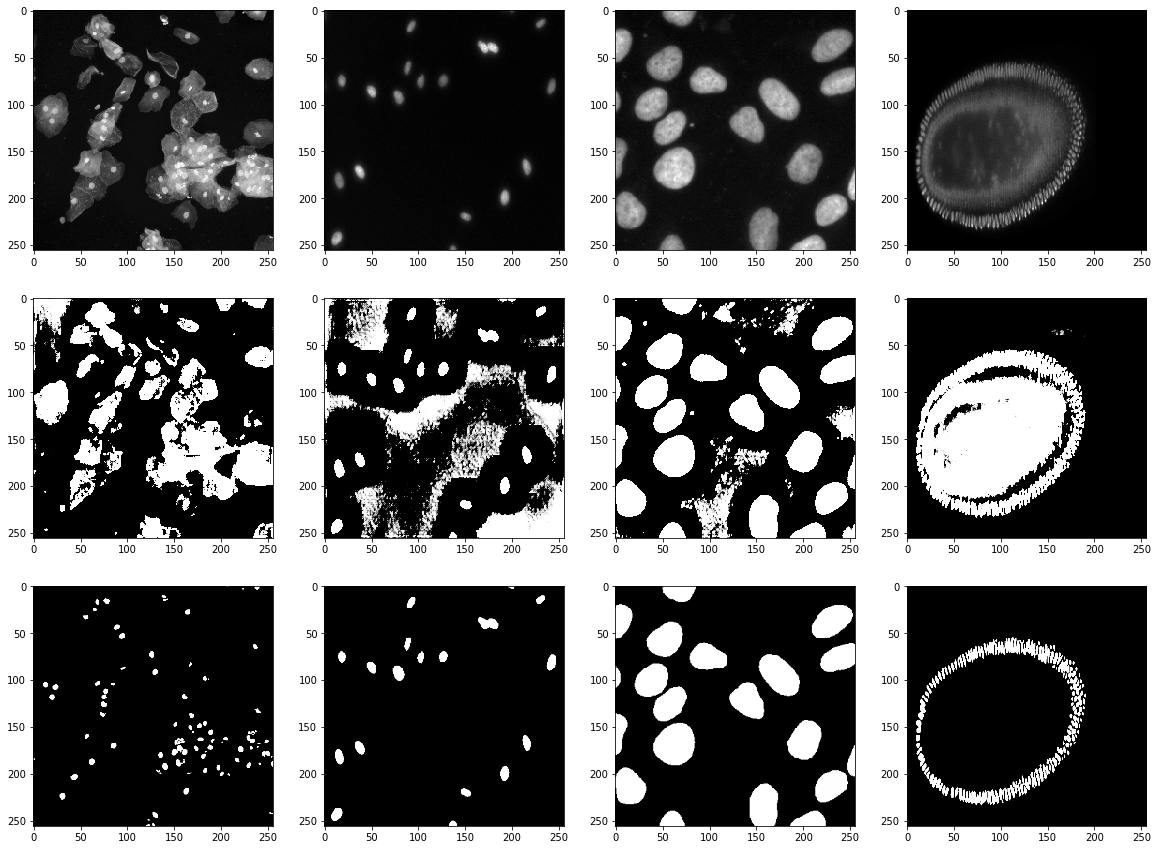

In [10]:
image_list= [8, 11, 12, 24]
f, axarr = plt.subplots(3, len(image_list), figsize=(20,15))
for idx, img_id in enumerate(image_list):
    y_pred = model.predict(np.expand_dims(X_test[img_id], 0))
    axarr[0, idx].imshow(X_test[img_id, :, : , 0].astype(np.float64), cmap='gray')
    axarr[1, idx].imshow(y_pred[0, :, : , 0], cmap='gray')
    axarr[2, idx].imshow(y_test[img_id, :, : , 0].astype(np.float64), cmap='gray')
plt.savefig("img/prediction_test.png")
plt.show()

# Getting best threshold for pixels

In [11]:
model = load_model("models/model_unet.h5")

Score (with threshold = 0.05) = 0.940
Score (with threshold = 0.10) = 0.866
Score (with threshold = 0.15) = 0.806
Score (with threshold = 0.20) = 0.731
Score (with threshold = 0.25) = 0.716
Score (with threshold = 0.30) = 0.657
Score (with threshold = 0.35) = 0.657
Score (with threshold = 0.40) = 0.627
Score (with threshold = 0.45) = 0.612
Score (with threshold = 0.50) = 0.582
Score (with threshold = 0.55) = 0.567
Score (with threshold = 0.60) = 0.493
Score (with threshold = 0.65) = 0.433
Score (with threshold = 0.70) = 0.358
Score (with threshold = 0.75) = 0.269
Score (with threshold = 0.80) = 0.060
Score (with threshold = 0.85) = 0.000
Score (with threshold = 0.90) = 0.000
Score (with threshold = 0.95) = 0.000


In [16]:
result_trigger = []
for trigger in [0.05 * i for i in range(5, 20)] + [0.97, 0.99, 0.999, 0.9999]:
    print(trigger)
    final_score = []
    threshold = [0.05 * i for i in range(10, 20)]
    for t in threshold:
        score = []
        for idx in range(NB_IMAGES_TEST):
            img = X_test[idx, :, : , :]
            pred = model.predict(np.expand_dims(img, 0))[0, :, : , 0]
            mask = y_test[idx, :, : , 0]
            dims = dim_test[idx].tolist()
            W, H = dims

            pred = cv2.resize(pred, (H, W))
            mask = cv2.resize(mask, (H, W))

            IOU = compute_IoU(pred, mask, trigger=trigger)  # if predicition of a specific pixel is above trigger, it is white
            if IOU >= t:
                score.append(1)
            else:
                score.append(0)
        final_score.append(sum(score)/len(score))
#         print("Score (with threshold = {:.2f}) = {:.3f}".format(t, sum(score)/len(score)))
    print("Final score = {:.3f}".format(sum(final_score)/len(final_score)))
    result_trigger.append(sum(final_score)/len(final_score))

0.25
Final score = 0.264
0.30000000000000004
Final score = 0.264
0.35000000000000003
Final score = 0.269
0.4
Final score = 0.269
0.45
Final score = 0.269
0.5
Final score = 0.272
0.55
Final score = 0.276
0.6000000000000001
Final score = 0.279
0.65
Final score = 0.279
0.7000000000000001
Final score = 0.287
0.75
Final score = 0.293
0.8
Final score = 0.301
0.8500000000000001
Final score = 0.310
0.9
Final score = 0.313
0.9500000000000001
Final score = 0.327
0.97
Final score = 0.333
0.99
Final score = 0.354
0.999
Final score = 0.391
0.9999
Final score = 0.421


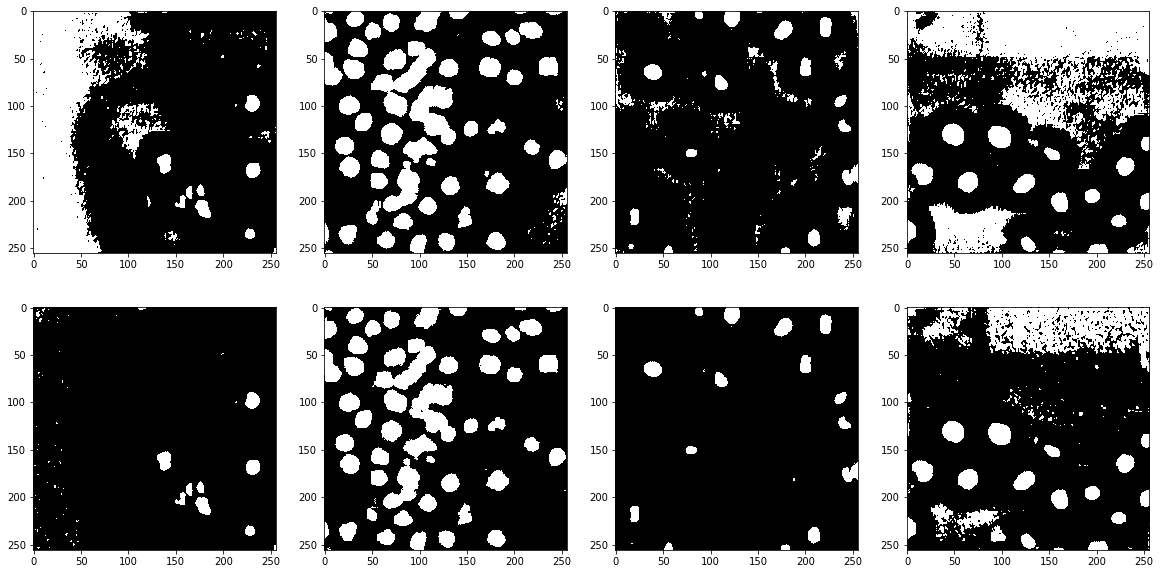

In [25]:
image_list= [8, 11, 12, 24]
f, axarr = plt.subplots(2, len(image_list), figsize=(20,10))
for idx, img_id in enumerate(image_list):
    img = X_test[idx, :, : , :]
    pred = model.predict(np.expand_dims(img, 0))[0, :, : , 0]
    mask = y_test[idx, :, : , 0]
    dims = dim_test[idx].tolist()
    W, H = dims

    pred = cv2.resize(pred, (H, W))
    mask = cv2.resize(mask, (H, W))
    
    axarr[0, idx].imshow(pred>0.3, cmap='gray')
    axarr[1, idx].imshow(pred>0.999999, cmap='gray')
plt.savefig("img/threshold_unet.png")
plt.show()

# Evaluation 

At the end of the training, we save the model. We can now evaluation the IoU on test set images. As our output is a sigmoid, we can also adjust our threashold for black/white pixel to improve IoU.

In [11]:
model = load_model("models/model_unet.h5")

In [19]:
final_score = []
threshold = [0.05 * i for i in range(10, 20)]
for t in threshold:
    score = []
    for idx in range(NB_IMAGES_TEST):
        img = X_test[idx, :, : , :]
        pred = model.predict(np.expand_dims(img, 0))[0, :, : , 0]
        mask = y_test[idx, :, : , 0]
        dims = dim_test[idx].tolist()
        W, H = dims
        
        pred = cv2.resize(pred, (H, W))
        mask = cv2.resize(mask, (H, W))

        IOU = compute_IoU(pred, mask, trigger=0.97)
        if IOU >= t:
            score.append(1)
        else:
            score.append(0)
    final_score.append(sum(score)/len(score))
    print("Score (with threshold = {:.2f}) = {:.3f}".format(t, sum(score)/len(score)))
print("Final score = {:.3f}".format(sum(final_score)/len(final_score)))

Score (with threshold = 0.50) = 0.701
Score (with threshold = 0.55) = 0.642
Score (with threshold = 0.60) = 0.612
Score (with threshold = 0.65) = 0.552
Score (with threshold = 0.70) = 0.448
Score (with threshold = 0.75) = 0.299
Score (with threshold = 0.80) = 0.075
Score (with threshold = 0.85) = 0.000
Score (with threshold = 0.90) = 0.000
Score (with threshold = 0.95) = 0.000
Final score = 0.333


Without the split to multi-mask, the IoU score is not so bad but we can see that we still have lot of noise. The prediction for Kaggle will be handled in another Notebook with only required points compiled. We can play with the trigger value which provide the threshold to consider a pixel white or black on the IoU function. but result won't go above 0.4. We we now see another model with a lot more performances.